In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from matplotlib import pyplot as plt
from torch import optim
from torchvision.transforms import transforms

In [2]:
torch.cuda.is_available()

True

In [3]:
vgg = models.vgg19(pretrained=True).features.to("cuda").eval()

In [4]:
list(vgg.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1

In [5]:
def fixRELUs(layer):
    if isinstance(layer, nn.ReLU):
        return nn.ReLU(inplace=False)
    return layer


layers = list(map(fixRELUs, vgg.children()))

In [6]:
class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()
        self.target = None

    def forward(self, input):
        if self.target is None:
            self.target = input.detach()
        else:
            self.loss = F.mse_loss(input, self.target)

        return input

In [7]:
class StyleLoss(nn.Module):
    @staticmethod
    def _gram_matrix(input):
        n, c, h, w = input.shape
        reshaped = input.reshape(n * c, h * w)
        return torch.mm(reshaped, reshaped.T).div(n * c * h * w)

    def __init__(self):
        super(StyleLoss, self).__init__()
        self.target = None

    def forward(self, input):
        if self.target is None:
            self.target = self._gram_matrix(input.detach()).detach()
        else:
            self.loss = F.mse_loss(self._gram_matrix(input), self.target)

        return input

In [8]:
layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [9]:
style_losses = [StyleLoss() for _ in range(5)]
content_loss = ContentLoss()

layers.insert(11, style_losses[0])
layers.insert(8, style_losses[1])
layers.insert(8, content_loss)
layers.insert(6, style_losses[2])
layers.insert(3, style_losses[3])
layers.insert(1, style_losses[4])

layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 StyleLoss(),
 ReLU(),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 StyleLoss(),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 StyleLoss(),
 ReLU(),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ContentLoss(),
 StyleLoss(),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 StyleLoss(),
 ReLU(),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
device = "cuda"
imsize = 512

def image_loader(image_name):
    image = Image.open(image_name)
    image = transforms.Compose([
        transforms.Resize([imsize, imsize]),
        transforms.ToTensor()]
    )(image).unsqueeze(0)
    return image.to(device).float()


content_img = image_loader("./data/images/mona_lisa.jpg")
style_img = image_loader("./data/images/van_gogh.jpeg")

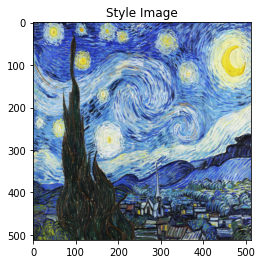

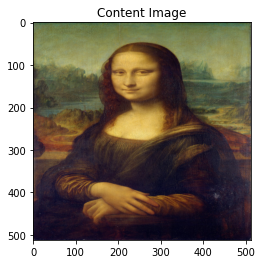

In [11]:
def imshow(tensor, title=None):
    image = transforms.ToPILImage()(tensor.cpu().clone().squeeze())
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

In [12]:
model = nn.Sequential(*layers)
# pass style_img and content_img through network to init losses
model(style_img)
content_loss.target = None
model(content_img)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1357, 0.0000, 0.0000,  ..., 0.0000, 0.2636, 0.3097],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5533]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [13]:
epochs = 500
style_weight = 1000000
content_weight = 1

In [21]:
content_img.requires_grad = True
model.requires_grad = False

optimizer = optim.Adam([content_img])

def criterion():
    return sum([style_loss.loss for style_loss in style_losses]) * style_weight + content_loss.loss * content_weight

for epoch in range(epochs):
    with torch.no_grad():
        content_img.clip_(0, 1)

    optimizer.zero_grad()
    model(content_img)

    loss = criterion()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch: {} Loss: {}'.format(epoch, loss.item()))

    with torch.no_grad():
        content_img.clip_(0, 1)

Epoch: 0 Loss: 4.307638168334961
Epoch: 10 Loss: 4.51270866394043
Epoch: 20 Loss: 4.364591598510742
Epoch: 30 Loss: 4.303150177001953
Epoch: 40 Loss: 4.291430473327637
Epoch: 50 Loss: 4.2840375900268555
Epoch: 60 Loss: 4.276614665985107
Epoch: 70 Loss: 4.269144535064697
Epoch: 80 Loss: 4.261346340179443
Epoch: 90 Loss: 4.253547668457031
Epoch: 100 Loss: 4.245738506317139
Epoch: 110 Loss: 4.2378106117248535
Epoch: 120 Loss: 4.229792594909668
Epoch: 130 Loss: 4.221682548522949
Epoch: 140 Loss: 4.213481426239014
Epoch: 150 Loss: 4.20519495010376
Epoch: 160 Loss: 4.196834564208984
Epoch: 170 Loss: 4.188403606414795
Epoch: 180 Loss: 4.179911136627197
Epoch: 190 Loss: 4.171363353729248
Epoch: 200 Loss: 4.162765979766846
Epoch: 210 Loss: 4.154121398925781
Epoch: 220 Loss: 4.145442962646484
Epoch: 230 Loss: 4.1367292404174805
Epoch: 240 Loss: 4.127986907958984
Epoch: 250 Loss: 4.119219779968262
Epoch: 260 Loss: 4.110439300537109
Epoch: 270 Loss: 4.101644992828369
Epoch: 280 Loss: 4.09283828735

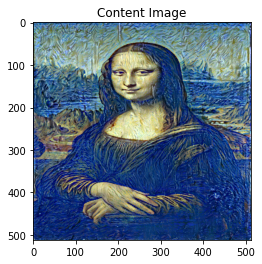

In [22]:
plt.figure()
imshow(content_img, title='Content Image')

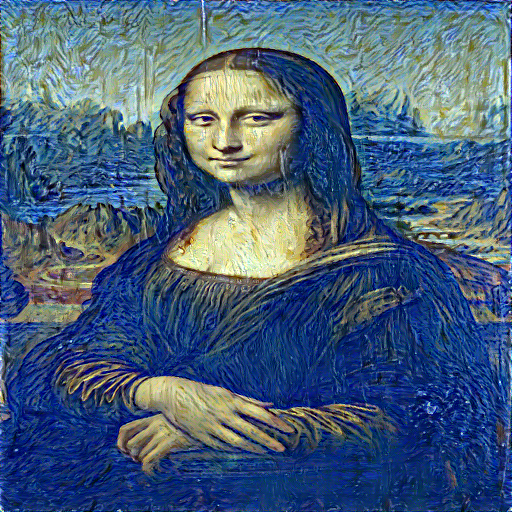

In [23]:
result = transforms.ToPILImage()(content_img.detach().cpu().squeeze())
result

In [24]:
result.save("./result.png")